### imports & load data

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('Energy_consumption.csv')

In [399]:
print("Loaded:", df.shape)

Loaded: (1000, 11)


In [400]:
display(df.head())

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


### Basic inspection

In [401]:
print("Columns and dtypes:\n", df.dtypes)

Columns and dtypes:
 Timestamp             object
Temperature          float64
Humidity             float64
SquareFootage        float64
Occupancy              int64
HVACUsage             object
LightingUsage         object
RenewableEnergy      float64
DayOfWeek             object
Holiday               object
EnergyConsumption    float64
dtype: object


In [402]:
print("\nMissing values:\n", df.isnull().sum())



Missing values:
 Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


In [403]:
# Convert Timestamp if present
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Normalize On/Off categorical to consistent case if present
for col in ['HVACUsage', 'LightingUsage', 'Holiday', 'DayOfWeek']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Convert On/Off to category or numeric flags
if 'HVACUsage' in df.columns:
    df['HVACUsage'] = df['HVACUsage'].astype('category')
    df['HVAC_On'] = df['HVACUsage'].map({'On':1, 'on':1, 'OFF':0, 'Off':0, 'off':0}).fillna(0).astype(int)
if 'LightingUsage' in df.columns:
    df['LightingUsage'] = df['LightingUsage'].astype('category')
    df['Lighting_On'] = df['LightingUsage'].map({'On':1, 'on':1, 'OFF':0, 'Off':0, 'off':0}).fillna(0).astype(int)


In [404]:
print("\nAfter fixes, dtypes:\n", df.dtypes)


After fixes, dtypes:
 Timestamp            datetime64[ns]
Temperature                 float64
Humidity                    float64
SquareFootage               float64
Occupancy                     int64
HVACUsage                  category
LightingUsage              category
RenewableEnergy             float64
DayOfWeek                    object
Holiday                      object
EnergyConsumption           float64
HVAC_On                       int64
Lighting_On                   int64
dtype: object


In [405]:
display(df.head())

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,HVAC_On,Lighting_On
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,1,0
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,0,0
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,0,1
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,1,0


In [406]:
numeric_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric columns used:\n", numeric_df.columns.tolist())

Numeric columns used:
 ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'HVAC_On', 'Lighting_On']


In [407]:
display(numeric_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.982026,2.836850,20.007565,22.645070,24.751637,27.418174,29.998671
Humidity,1000.0,45.395412,8.518905,30.015975,38.297722,45.972116,52.420066,59.969085
SquareFootage,1000.0,1500.052488,288.418873,1000.512661,1247.108548,1507.967426,1740.340165,1999.982252
Occupancy,1000.0,4.581000,2.865598,0.000000,2.000000,5.000000,7.000000,9.000000
RenewableEnergy,1000.0,15.132813,8.745917,0.006642,7.628385,15.072296,22.884064,29.965327
EnergyConsumption,1000.0,77.055873,8.144112,53.263278,71.544690,76.943696,82.921742,99.201120
HVAC_On,1000.0,0.492000,0.500186,0.000000,0.000000,0.000000,1.000000,1.000000
Lighting_On,1000.0,0.491000,0.500169,0.000000,0.000000,0.000000,1.000000,1.000000


### Outlier detection

In [408]:
numeric_cols = numeric_df.columns
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

In [409]:
outliers_counts = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()
print("Outlier counts per numeric column:\n", outliers_counts)

Outlier counts per numeric column:
 Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
RenewableEnergy      0
EnergyConsumption    1
HVAC_On              0
Lighting_On          0
dtype: int64


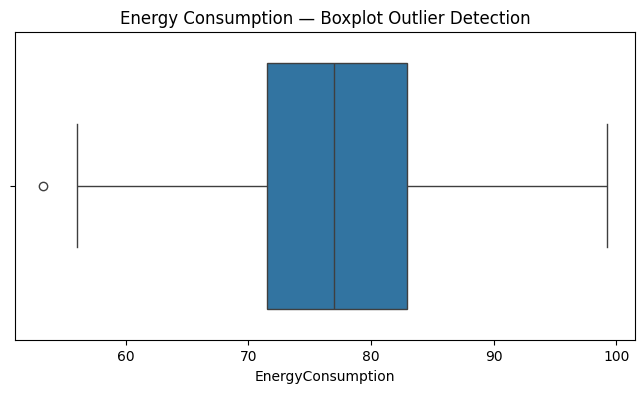

In [410]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['EnergyConsumption'])
plt.title("Energy Consumption — Boxplot Outlier Detection")
plt.show()

In [411]:
energy_outliers = df[(df['EnergyConsumption'] < (Q1['EnergyConsumption'] - 1.5 * IQR['EnergyConsumption'])) |
                     (df['EnergyConsumption'] > (Q3['EnergyConsumption'] + 1.5 * IQR['EnergyConsumption']))]
print("Energy outlier rows found:", len(energy_outliers))

Energy outlier rows found: 1


In [412]:
display(energy_outliers)

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,HVAC_On,Lighting_On
69,2022-01-03 21:00:00,20.735716,48.506636,1836.542651,4,Off,On,9.295439,Friday,No,53.263278,0,1


In [413]:
df = df[(df['EnergyConsumption'] >= (Q1['EnergyConsumption'] - 1.5 * IQR['EnergyConsumption'])) &
        (df['EnergyConsumption'] <= (Q3['EnergyConsumption'] + 1.5 * IQR['EnergyConsumption']))].reset_index(drop=True)
numeric_df = df.select_dtypes(include=[np.number]).copy()


#### Save a clean copy

In [414]:
df.to_csv("energy_cleaned.csv", index=False)

### Feature engineering

In [415]:
df['Energy_per_Person'] = df['EnergyConsumption'] / (df['Occupancy'] + 1)

df['Renewable_Ratio'] = df['RenewableEnergy'] / df['EnergyConsumption']
df['Renewable_Ratio'] = df['Renewable_Ratio'].replace([np.inf, -np.inf], np.nan)
df['Renewable_Ratio'] = df['Renewable_Ratio'].fillna(0)

display(df[['EnergyConsumption','Occupancy','Energy_per_Person','RenewableEnergy','Renewable_Ratio']].head())


,EnergyConsumption,Occupancy,Energy_per_Person,RenewableEnergy,Renewable_Ratio
0,75.364373,5,12.560729,2.774699,0.036817
1,83.401855,1,41.700927,21.831384,0.261761
2,78.270888,2,26.090296,6.764672,0.086426
3,56.519850,1,28.259925,8.623447,0.152574
4,70.811732,9,7.081173,3.071969,0.043382


### Exploratory plots

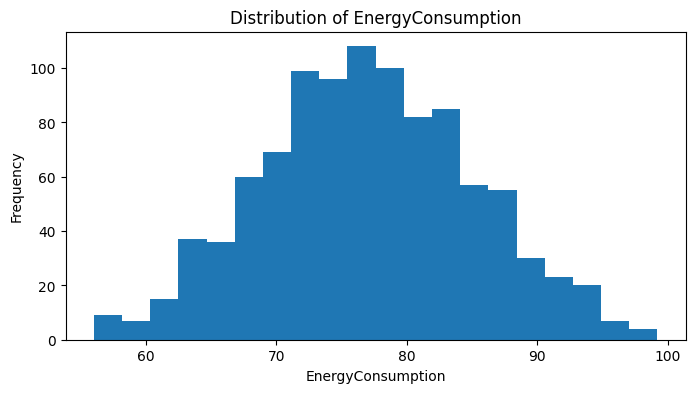

In [416]:
plt.figure(figsize=(8,4))
plt.hist(df['EnergyConsumption'], bins=20)
plt.title("Distribution of EnergyConsumption")
plt.xlabel("EnergyConsumption")
plt.ylabel("Frequency")
plt.show()


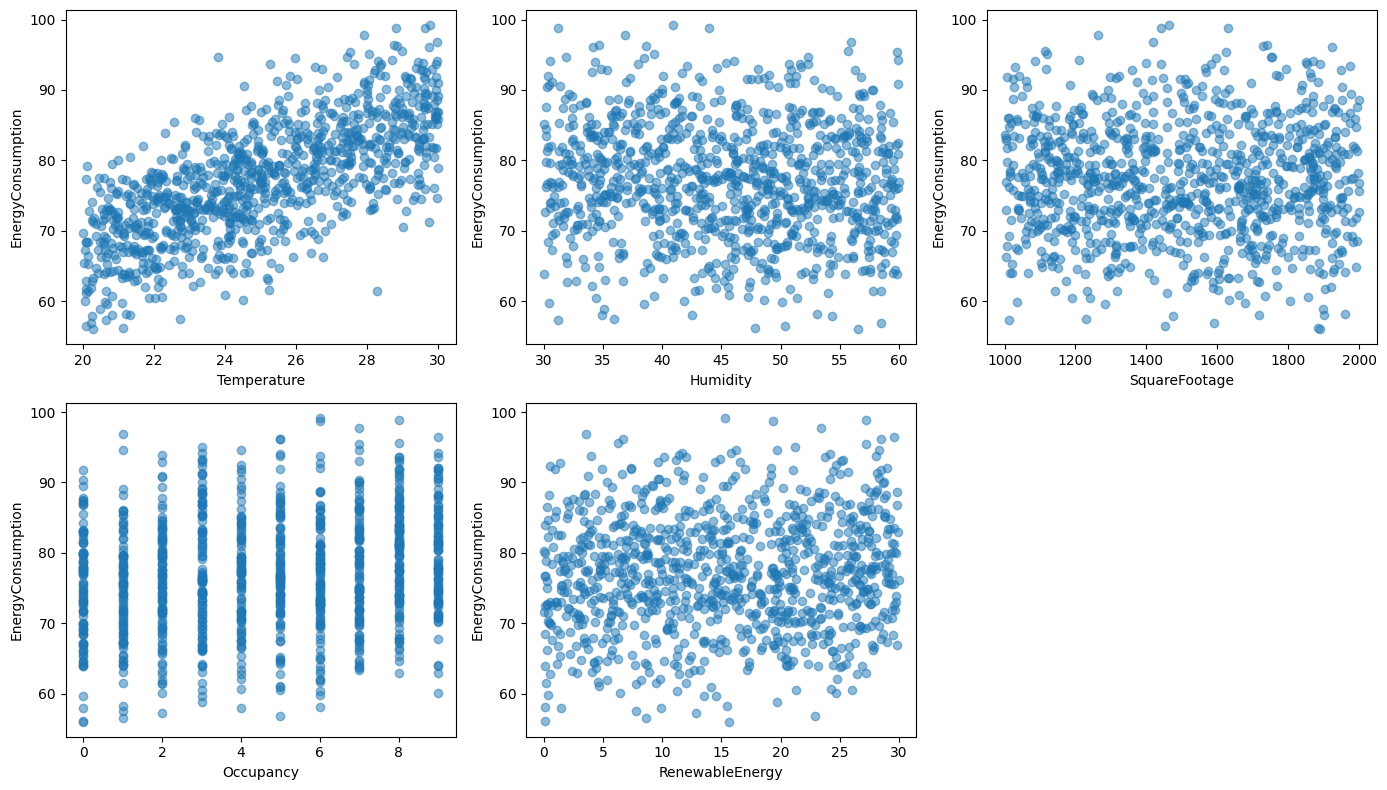

In [417]:
features = ['Temperature','Humidity','SquareFootage','Occupancy','RenewableEnergy']
plt.figure(figsize=(14,8))
for i, col in enumerate(features, 1):
    plt.subplot(2,3,i)
    plt.scatter(df[col], df['EnergyConsumption'], alpha=0.5)
    plt.xlabel(col); plt.ylabel('EnergyConsumption')
plt.tight_layout()
plt.show()


### Correlation heatmap

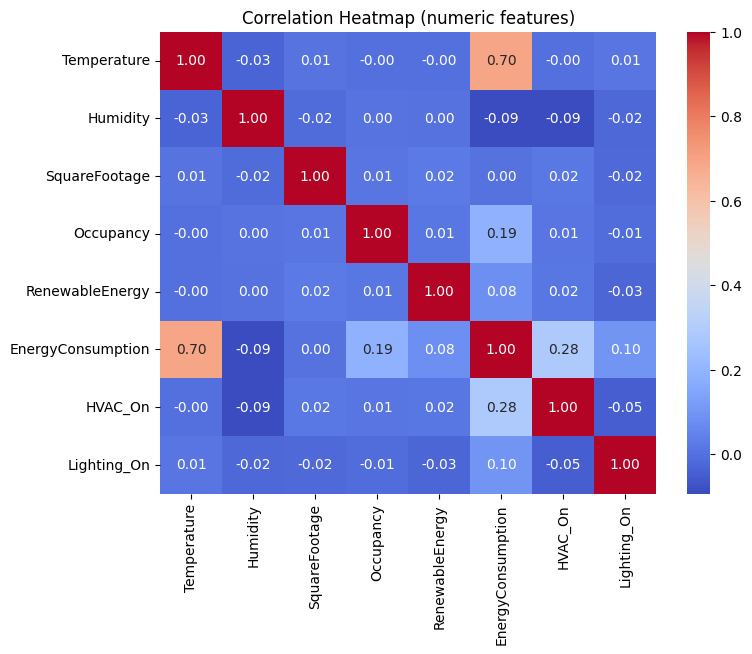

In [418]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

In [419]:
print("Correlation with EnergyConsumption:")
print(numeric_df.corr()['EnergyConsumption'].sort_values(ascending=False))

Correlation with EnergyConsumption:
EnergyConsumption    1.000000
Temperature          0.695788
HVAC_On              0.284944
Occupancy            0.186791
Lighting_On          0.096868
RenewableEnergy      0.079565
SquareFootage        0.002298
Humidity            -0.092918
Name: EnergyConsumption, dtype: float64


### Train-test split

In [420]:
predictors = ['Temperature','Humidity','SquareFootage','Occupancy','RenewableEnergy']  # modify if you want HVAC_On, etc
for flag in ['HVAC_On','Lighting_On']:
    if flag in df.columns and flag not in predictors:
        predictors.append(flag)

X = df[predictors].copy()
Y = df['EnergyConsumption'].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (799, 7) Test: (200, 7)


##### Linear Regression

In [421]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(Y_test, Y_pred_lr)
r2_lr = r2_score(Y_test, Y_pred_lr)
print("Linear Regression - MSE: {:.4f}, R2: {:.4f}".format(mse_lr, r2_lr))


Linear Regression - MSE: 25.4597, R2: 0.5873


In [422]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_}).sort_values(by='Coefficient', key=abs, ascending=False)
display(coef_df)

,Feature,Coefficient
5,HVAC_On,4.896988
0,Temperature,1.990605
6,Lighting_On,1.496729
3,Occupancy,0.511319
4,RenewableEnergy,0.072118
1,Humidity,-0.028137
2,SquareFootage,-0.000073


##### Ridge & Lasso

In [423]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.001)

ridge.fit(X_train, Y_train)
lasso.fit(X_train, Y_train)

Y_pred_ridge = ridge.predict(X_test)
Y_pred_lasso = lasso.predict(X_test)

print("Ridge - MSE: {:.4f}, R2: {:.4f}".format(mean_squared_error(Y_test, Y_pred_ridge), r2_score(Y_test, Y_pred_ridge)))
print("Lasso - MSE: {:.4f}, R2: {:.4f}".format(mean_squared_error(Y_test, Y_pred_lasso), r2_score(Y_test, Y_pred_lasso)))


Ridge - MSE: 25.4454, R2: 0.5875
Lasso - MSE: 25.4592, R2: 0.5873


### Decision Tree complexity

In [424]:
depths = list(range(1,11))
train_r2 = []
test_r2 = []
train_mse = []
test_mse = []

for d in depths:
    m = DecisionTreeRegressor(max_depth=d, random_state=42)
    m.fit(X_train, Y_train)
    pred_train = m.predict(X_train)
    pred_test = m.predict(X_test)

    train_r2.append(r2_score(Y_train, pred_train))
    test_r2.append(r2_score(Y_test, pred_test))
    train_mse.append(mean_squared_error(Y_train, pred_train))
    test_mse.append(mean_squared_error(Y_test, pred_test))

    print(f"Depth={d} Train R2={train_r2[-1]:.3f} Test R2={test_r2[-1]:.3f}")


Depth=1 Train R2=0.389 Test R2=0.257
Depth=2 Train R2=0.481 Test R2=0.356
Depth=3 Train R2=0.564 Test R2=0.457
Depth=4 Train R2=0.614 Test R2=0.489
Depth=5 Train R2=0.678 Test R2=0.410
Depth=6 Train R2=0.753 Test R2=0.335
Depth=7 Train R2=0.822 Test R2=0.219
Depth=8 Train R2=0.882 Test R2=0.155
Depth=9 Train R2=0.921 Test R2=0.121
Depth=10 Train R2=0.947 Test R2=0.063


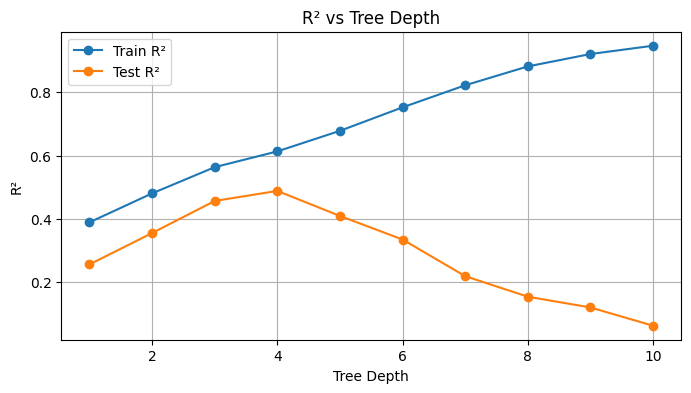

In [425]:
plt.figure(figsize=(8,4))
plt.plot(depths, train_r2, marker='o', label='Train R²')
plt.plot(depths, test_r2, marker='o', label='Test R²')
plt.xlabel("Tree Depth"); plt.ylabel("R²"); plt.title("R² vs Tree Depth")
plt.legend(); plt.grid(True); plt.show()

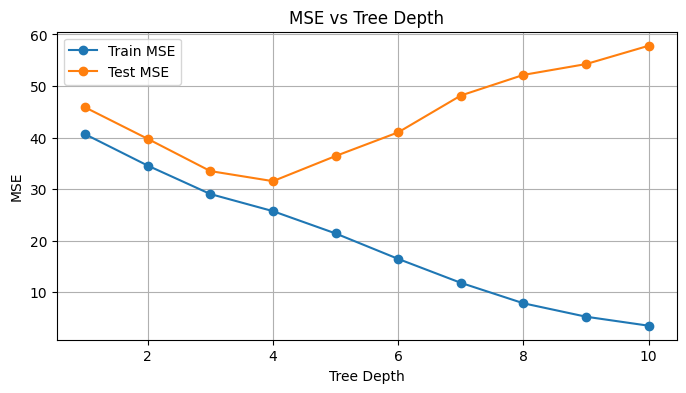

In [426]:

plt.figure(figsize=(8,4))
plt.plot(depths, train_mse, marker='o', label='Train MSE')
plt.plot(depths, test_mse, marker='o', label='Test MSE')
plt.xlabel("Tree Depth"); plt.ylabel("MSE"); plt.title("MSE vs Tree Depth")
plt.legend(); plt.grid(True); plt.show()


### Train a final Decision Tree and Random Forest; compare models

In [427]:
best_depth = 5
dt = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dt.fit(X_train, Y_train)
Y_pred_dt = dt.predict(X_test)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

In [428]:
models_results = {
    "Linear": (mse_lr, r2_lr),
    "Ridge": (mean_squared_error(Y_test, Y_pred_ridge), r2_score(Y_test, Y_pred_ridge)),
    "Lasso": (mean_squared_error(Y_test, Y_pred_lasso), r2_score(Y_test, Y_pred_lasso)),
    f"Tree_d{best_depth}": (mean_squared_error(Y_test, Y_pred_dt), r2_score(Y_test, Y_pred_dt)),
    "RandomForest": (mean_squared_error(Y_test, Y_pred_rf), r2_score(Y_test, Y_pred_rf)),
}

results_df = pd.DataFrame([
    {"Model":k, "MSE":v[0], "R2":v[1]} for k,v in models_results.items()
])
display(results_df)


,Model,MSE,R2
0,Linear,25.459712,0.587277
1,Ridge,25.445379,0.587509
2,Lasso,25.459195,0.587286
3,Tree_d5,36.419049,0.409617
4,RandomForest,30.081728,0.512350


##### Random Forest feature importance

In [429]:
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)
display(feat_imp)

,Feature,Importance
0,Temperature,0.583712
4,RenewableEnergy,0.087557
5,HVAC_On,0.083872
2,SquareFootage,0.082039
3,Occupancy,0.074676
1,Humidity,0.074511
6,Lighting_On,0.013633


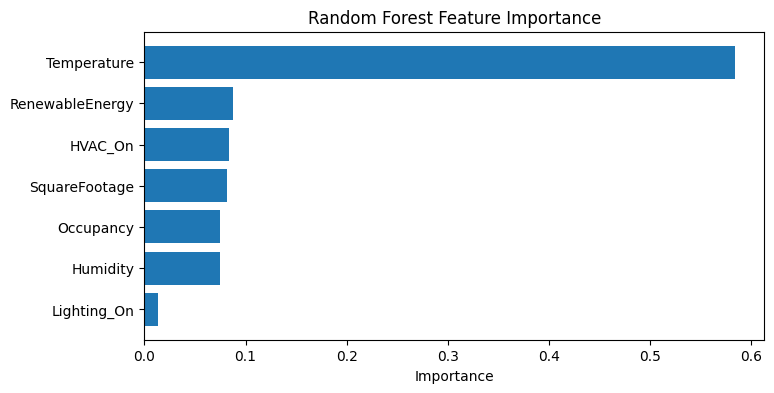

In [430]:
plt.figure(figsize=(8,4))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel("Importance"); plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis(); plt.show()


### Residual analysis

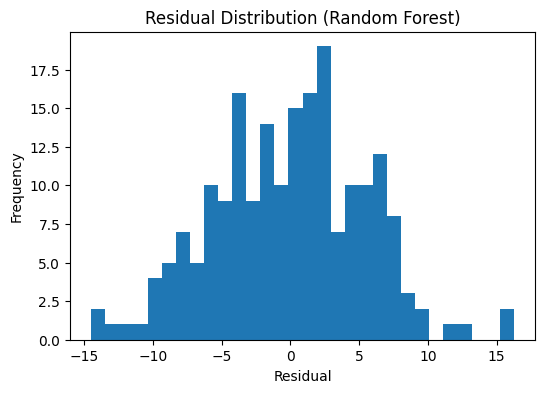

In [431]:
df_results = X_test.copy()
df_results['Actual'] = Y_test.values
df_results['Pred_RF'] = Y_pred_rf
df_results['Residuals'] = df_results['Actual'] - df_results['Pred_RF']

plt.figure(figsize=(6,4))
plt.hist(df_results['Residuals'], bins=30)
plt.title("Residual Distribution (Random Forest)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.show()

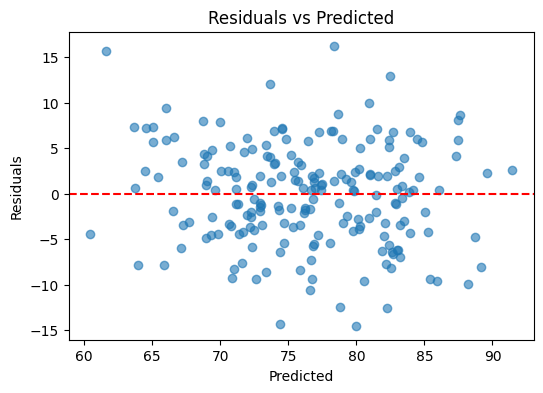

In [432]:
plt.figure(figsize=(6,4))
plt.scatter(df_results['Pred_RF'], df_results['Residuals'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals vs Predicted")
plt.show()

### Actual vs Predicted variants

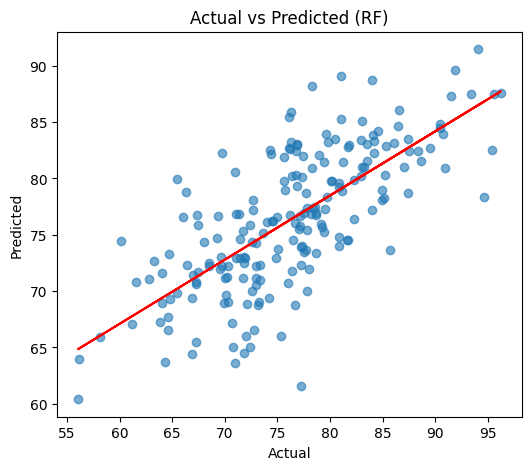

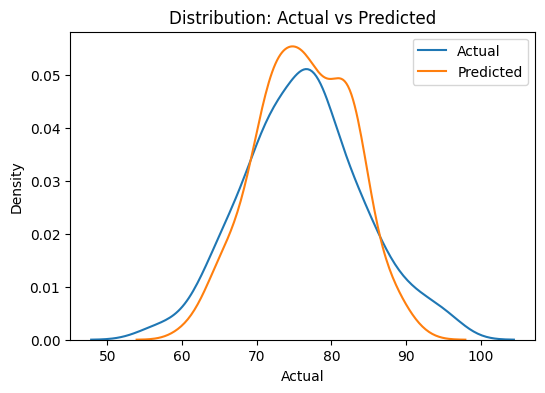

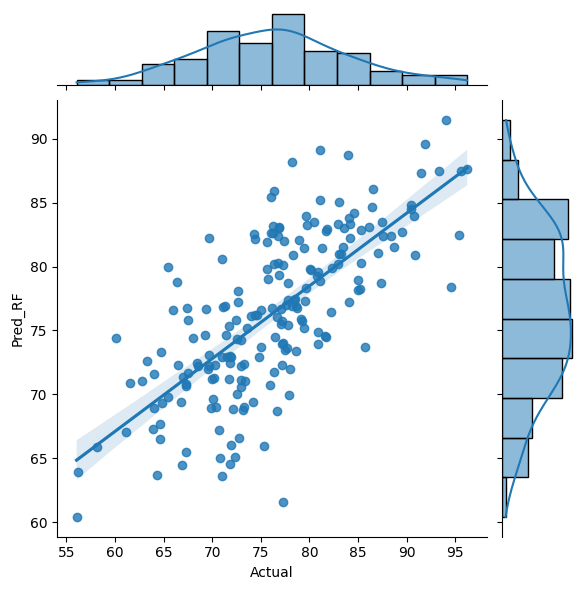

In [433]:
plt.figure(figsize=(6,5))
plt.scatter(df_results['Actual'], df_results['Pred_RF'], alpha=0.6)
m, b = np.polyfit(df_results['Actual'], df_results['Pred_RF'], 1)
plt.plot(df_results['Actual'], m*df_results['Actual'] + b, color='red')
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Actual vs Predicted (RF)")
plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(df_results['Actual'], label='Actual')
sns.kdeplot(df_results['Pred_RF'], label='Predicted')
plt.title("Distribution: Actual vs Predicted")
plt.legend(); plt.show()

sns.jointplot(x='Actual', y='Pred_RF', data=df_results, kind='reg', height=6)
plt.show()


In [434]:
out = X_test.copy()
out['Actual_Energy'] = Y_test.values
out['Pred_RF'] = Y_pred_rf
out['Pred_LR'] = Y_pred_lr
out.to_csv("energy_model_predictions.csv", index=False)
print("Saved energy_model_predictions.csv")


Saved energy_model_predictions.csv


### Short summary

In [435]:
best_model = results_df.sort_values('R2', ascending=False).iloc[0]
summary = f"""
Final summary:
- Dataset rows: {df.shape[0]}
- Features used: {predictors}
- Best model by R2: {best_model['Model']} with R2={best_model['R2']:.3f} and MSE={best_model['MSE']:.3f}
- Top features by RandomForest: {list(feat_imp['Feature'].head(3))}
"""
print(summary)



Final summary:
- Dataset rows: 999
- Features used: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'HVAC_On', 'Lighting_On']
- Best model by R2: Ridge with R2=0.588 and MSE=25.445
- Top features by RandomForest: ['Temperature', 'RenewableEnergy', 'HVAC_On']

